In [5]:
import numpy as np
import matplotlib.pyplot as plt

from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors.oracle import Oracle

In [2]:
sim = Simulation()

platform = LTIObject(1, np.array([0, 0, 0]), sim, np.zeros((3, 3)))
oracle = Oracle(1, platform, np.eye(3) * 2.25)
platform.add_payload(oracle)

target_W = np.zeros((6, 6))
target_W[0, 0] = 0.25
target_W[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_W)

sim._sim_objects.extend([platform, target])

In [3]:
sim_records = sim.run()

In [4]:
sim_records

{'oracle1': {'t': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
          5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
         11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
         16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
         22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
         27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
         33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
         38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
         44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
         49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
         55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ]),
  'sensor_id': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

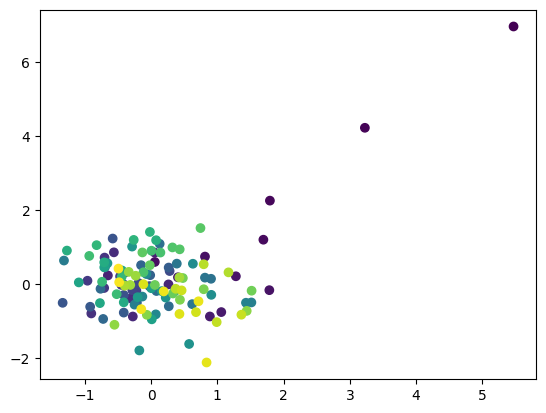

In [8]:
plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], c=sim_records["lti_object2"]["t"])

In [9]:
target.F

array([[0.5, 0. , 0. , 0.5, 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5]])